In [64]:
#pip install datasets
#pip install keybert

Librerías

In [154]:
import pandas as pd
import json
import datasets
from datasets import load_dataset
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from keybert import KeyBERT
kw_model = KeyBERT()
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import yake
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alicia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alicia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alicia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Carga y procesamiento de datos 

In [131]:
dataset = load_dataset("midas/duc2001", "generation")
dataset

Found cached dataset duc2001 (C:/Users/Alicia/.cache/huggingface/datasets/midas___duc2001/generation/0.0.1/7888b46165d8a58f49f00e28410b46b1f22fabfd72a9e89f3e80a4e2d27e4a9b)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['id', 'document', 'extractive_keyphrases', 'abstractive_keyphrases'],
        num_rows: 308
    })
})

DatasetDict({
    test: Dataset({
        features: ['id', 'document', 'extractive_keyphrases', 'abstractive_keyphrases'],
        num_rows: 308
    })
})

In [132]:
def drop_column(dataset):
    del dataset['abstractive_keyphrases'] # Para eliminar la columna que no necesitamos
    return dataset

dataset = dataset.map(drop_column)

Loading cached processed dataset at C:\Users\Alicia\.cache\huggingface\datasets\midas___duc2001\generation\0.0.1\7888b46165d8a58f49f00e28410b46b1f22fabfd72a9e89f3e80a4e2d27e4a9b\cache-16ebf8679ee254b4.arrow


In [133]:
extractive_keyphrases_list = []

for sublista in dataset['test']['extractive_keyphrases']:
    sublista_filtrada = [frase for frase in sublista if len(frase.split()) <= 3] # Eliminamos de la columna extractive_keyphrases las keyphrases con n-gramas >3
    extractive_keyphrases_list.append(sublista_filtrada)


In [134]:
dataset # Hasta aquí tenemos un dataset con las 3 columnas de interés:

DatasetDict({
    test: Dataset({
        features: ['id', 'document', 'extractive_keyphrases'],
        num_rows: 308
    })
})

In [135]:
# guardar el numero de extractive keyphrases que hay para cada doc (esto es necesario para luego calcular la precisión)

n_extractive_keyphrases = []
for sublista in extractive_keyphrases_list:
    num_elementos = len(sublista)
    n_extractive_keyphrases.append(num_elementos)

Importación stop_words para los modelos

In [136]:
stop_words = stopwords.words('english')

Combinaciones validas POS tag 

In [137]:
# Combinaciones que nos interesan
adjectives = ['JJ', 'JJR', 'JJS']
nouns = ['NN', 'NNS', 'NNP', 'NNPS']
prepositions = ['IN']

patterns = []

# adjective-noun
patterns.extend([(adj, noun) for adj in adjectives for noun in nouns])

# noun-noun
patterns.extend([(noun1, noun2) for noun1 in nouns for noun2 in nouns])

# adjective-adjective-noun
patterns.extend([(adj1, adj2, noun) for adj1 in adjectives for adj2 in adjectives for noun in nouns])

# adjective-noun-noun
patterns.extend([(adj, noun1, noun2) for adj in adjectives for noun1 in nouns for noun2 in nouns])

# noun-adjective-noun
patterns.extend([(noun1, adj, noun2) for noun1 in nouns for adj in adjectives for noun2 in nouns])

# noun-noun-noun
patterns.extend([(noun1, noun2, noun3) for noun1 in nouns for noun2 in nouns for noun3 in nouns])

# noun-preposition-noun
patterns.extend([(noun1, prep, noun2) for noun1 in nouns for prep in prepositions for noun2 in nouns])

# imprimir todas las combinaciones posibles
#print(patterns)

print(len(patterns))

240


KeyBERT MMR

In [138]:
# Aplicación algoritmo KeyBERT
MMR_keywords = []
MMR_scores = []  

for i in range(len(dataset['test'])):
    joined_text = " ".join(dataset['test'][i]['document'])
    keywords_row = []
    score_row = []  
    for keyword_info in kw_model.extract_keywords(joined_text, keyphrase_ngram_range=(1, 3), stop_words=stop_words, use_mmr=True, #nltk lista stop words
                                                 top_n=40, diversity=0.7):
        keyword, score = keyword_info  # extraer palabra clave y puntuación
        keywords_row.append(keyword) 
        score_row.append(score) 
    MMR_keywords.append(keywords_row)
    MMR_scores.append(score_row)  

# A continuación sacamos las categorias gramaticales de cada keyword/keyphrase:
MMR_keyphrases_pos = []

for keyword_list in MMR_keywords:
    sublist_keyphrases_pos = []
    for keyword in keyword_list:
        palabras = word_tokenize(keyword)
        etiquetas = pos_tag(palabras)
        sublist_keyphrases_pos.append(etiquetas)
    MMR_keyphrases_pos.append(sublist_keyphrases_pos)    

# Quitamos las que tienen una combinación diferente a las que nos interesan:   (TAMBIÉN  nos quedamos con las de long 1)
MMR_keyphrases_pos_list = []  

for i in range(len(MMR_keyphrases_pos)):

    filtered_list = list(filter(list, MMR_keyphrases_pos[i])) # quita los elementos que son listas vacías

    if len(filtered_list) > 0: #Si queda algun elemento en la lista filtro los patrones válidos. Esto es solo es necesario para las keyphrases con más de un 1-ngram.

        valid_patterns = list(filter(lambda y: len(y[1]) == 1 or y[1] in patterns, map(lambda x: [' '.join([pos[0] for pos in x]), tuple([pos[1] for pos in x])], filtered_list)))

        MMR_keyphrases_pos_list.append(valid_patterns)
    else:
        MMR_keyphrases_pos_list.append([])    


KeyBERT MAXSUM

In [139]:
MS_keywords = []
MS_scores = []  

for i in range(len(dataset['test'])):
    joined_text = " ".join(dataset['test'][i]['document'])
    keywords_row = []
    score_row = []  
    for keyword_info in kw_model.extract_keywords(joined_text, keyphrase_ngram_range=(1, 3), stop_words=stop_words, use_maxsum=True, #nltk lista stop words
                                                  nr_candidates=40, top_n=40):
        keyword, score = keyword_info  # extraer palabra clave y puntuación
        keywords_row.append(keyword) 
        score_row.append(score) 
    MS_keywords.append(keywords_row)
    MS_scores.append(score_row)  

# A continuación sacamos las categorias gramaticales de cada keyword/keyphrase:
MS_keyphrases_pos = []

for keyword_list in MS_keywords:
    sublist_keyphrases_pos = []
    for keyword in keyword_list:
        palabras = word_tokenize(keyword)
        etiquetas = pos_tag(palabras)
        sublist_keyphrases_pos.append(etiquetas)
    MS_keyphrases_pos.append(sublist_keyphrases_pos)    

# Quitamos las que tienen una combinación diferente a las que nos interesan:   (TAMBIÉN  nos quedamos con las de long 1)
MS_keyphrases_pos_list = []  

for i in range(len(MS_keyphrases_pos)):

    filtered_list = list(filter(list, MS_keyphrases_pos[i])) # quita los elementos que son listas vacías

    if len(filtered_list) > 0: #Si queda algun elemento en la lista filtro los patrones válidos. Esto es solo es necesario para las keyphrases con más de un 1-ngram.

        valid_patterns = list(filter(lambda y: len(y[1]) == 1 or y[1] in patterns, map(lambda x: [' '.join([pos[0] for pos in x]), tuple([pos[1] for pos in x])], filtered_list)))

        MS_keyphrases_pos_list.append(valid_patterns)
    else:
        MS_keyphrases_pos_list.append([]) 

YAKE

In [175]:
language = "en"
max_ngram_size = 3
deduplication_threshold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 40

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)

Y_keywords = []
for i in range(len(dataset['test'])):
    joined_text = " ".join(dataset['test'][i]['document'])
    keywords_row = []
    for keyword_info in custom_kw_extractor.extract_keywords(joined_text):
        keyword, score = keyword_info  # extraer palabra clave y puntuación
        keywords_row.append((keyword)) # guardar información en una tupla
    Y_keywords.append(keywords_row) # guardar información de palabras clave para cada fila

# A continuación sacamos las categorias gramaticales de cada keyword/keyphrase:
Y_keyphrases_pos = []

for keyword_list in Y_keywords:
    sublist_keyphrases_pos = []
    for keyword in keyword_list:
        palabras = word_tokenize(keyword)
        etiquetas = pos_tag(palabras)
        sublist_keyphrases_pos.append(etiquetas)
    Y_keyphrases_pos.append(sublist_keyphrases_pos)    

# Quitamos las que tienen una combinación diferente a las que nos interesan:   (TAMBIÉN  nos quedamos con las de long 1)
Y_keyphrases_pos_list = []  

for i in range(len(Y_keyphrases_pos)):

    filtered_list = list(filter(list, Y_keyphrases_pos[i])) # quita los elementos que son listas vacías

    if len(filtered_list) > 0: #Si queda algun elemento en la lista filtro los patrones válidos. Esto es solo es necesario para las keyphrases con más de un 1-ngram.

        valid_patterns = list(filter(lambda y: len(y[1]) == 1 or y[1] in patterns, map(lambda x: [' '.join([pos[0] for pos in x]), tuple([pos[1] for pos in x])], filtered_list)))

        Y_keyphrases_pos_list.append(valid_patterns)
    else:
        Y_keyphrases_pos_list.append([]) 

Cálculo métricas: recall y precisión

In [176]:
# Función
def n_keyphrases(keyphrases_pos_list, n):
    keybert_list = [[elem[0] for elem in sublist] for sublist in keyphrases_pos_list]
    keywords = [sublista[:n] for sublista in keybert_list]
    n_matches = []
    for sub1, sub2 in zip(keywords, extractive_keyphrases_list):
        contador = 0
        for elem in sub1:
            if elem in sub2:
                contador += 1
        n_matches.append(contador)
    
    n_keybert_keyphrases = []
    for sublista in keyphrases_pos_list:    
        num_elementos = len([x for x in sublista if x != []])
        n_keybert_keyphrases.append(min(num_elementos, n))  
    
    recall = [] # Para calcular el recall obtenido en cada doc: n keyphrases obtenidas con keybert que hacen match / las extractive keyphrases que hay para cada doc   (n_matches/n_extractive_keyphrases)
    for x, y in zip(n_matches, n_extractive_keyphrases):
        recall.append(x / y)
    
    precision = [] # Para calcular la precisión obtenida en cada doc: n keyphrases obtenidas con keybert que hacen match / n keyphrases obtenidas con keybert para cada doc   (n_matches/n_keybert_keyphrases)
    for x, y in zip(n_matches, n_keybert_keyphrases):
        if y > 0:
            precision.append(x / y)
        else:
            precision.append(0.0)
    
    recall_mean = sum(recall) / len(recall)
    precision_mean = sum(precision) / len(precision)
    
    return  recall_mean, precision_mean


In [185]:
# Aplicación función
n_values = [3, 5, 10, 12, 20]

# MMR
MMR_overall_recall = []
MMR_overall_precision = []

for n in n_values:
    recall_mean, precision_mean = n_keyphrases(MMR_keyphrases_pos_list, n)
    MMR_overall_recall.append(round(recall_mean, 3))
    MMR_overall_precision.append(round(precision_mean, 3))

print("MMR Overall Recall:", MMR_overall_recall)
print("MMR Overall Precision:", MMR_overall_precision)

# MS
MS_overall_recall = []
MS_overall_precision = []

for n in n_values:
    recall_mean, precision_mean = n_keyphrases(MS_keyphrases_pos_list, n)
    MS_overall_recall.append(round(recall_mean, 3))
    MS_overall_precision.append(round(precision_mean, 3))

print("MS Overall Recall:", MS_overall_recall)
print("MS Overall Precision:", MS_overall_precision)

# YAKE
Y_overall_recall = []
Y_overall_precision = []

for n in n_values:
    recall_mean, precision_mean = n_keyphrases(Y_keyphrases_pos_list, n)
    Y_overall_recall.append(round(recall_mean, 3))
    Y_overall_precision.append(round(precision_mean, 3))

print("Y Overall Recall:", Y_overall_recall)
print("Y Overall Precision:", Y_overall_precision)



MMR Overall Recall: [0.021, 0.026, 0.034, 0.038, 0.042]
MMR Overall Precision: [0.039, 0.029, 0.019, 0.018, 0.014]
MS Overall Recall: [0.028, 0.045, 0.092, 0.127, 0.209]
MS Overall Precision: [0.061, 0.059, 0.063, 0.072, 0.08]
Y Overall Recall: [0.02, 0.03, 0.079, 0.094, 0.151]
Y Overall Precision: [0.039, 0.036, 0.049, 0.049, 0.049]


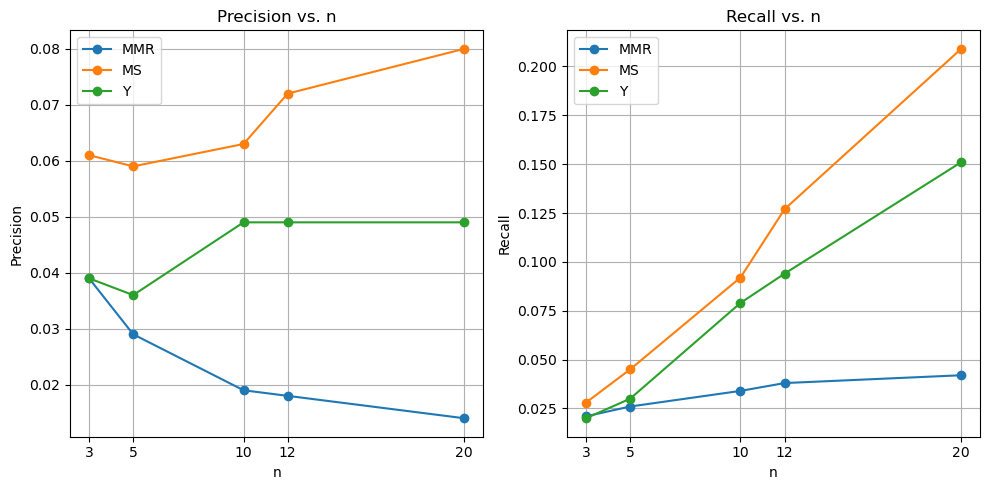

In [186]:
# Plot Precision and Recall side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot Precision
axs[0].plot(n_values, MMR_overall_precision, marker='o', label='MMR')
axs[0].plot(n_values, MS_overall_precision, marker='o', label='MS')
axs[0].plot(n_values, Y_overall_precision, marker='o', label='Y')

axs[0].set_xlabel('n')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision vs. n')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xticks(n_values)

# Plot Recall
axs[1].plot(n_values, MMR_overall_recall, marker='o', label='MMR')
axs[1].plot(n_values, MS_overall_recall, marker='o', label='MS')
axs[1].plot(n_values, Y_overall_recall, marker='o', label='Y')

axs[1].set_xlabel('n')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall vs. n')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xticks(n_values)

plt.tight_layout()
plt.show()


#######################################################################################################################################################################################

#######################################################################################################################################################################################